# Lab Assignment Four: Multi-Layer Perceptron

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Load, Split, and Balance 


#### 1.1 Load Dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/acs2017_census_tract_data.csv')
print('Unaltered data shape:',data.shape)

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
print('Fixed data shape:', data.shape)

data.drop(columns=['TractId', 'County'], inplace=True)
data.head()

Unaltered data shape: (74001, 37)
Fixed data shape: (72718, 37)


,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,Alabama,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,Alabama,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,Alabama,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,Alabama,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We will remove the 'county' column, to simplify the model to make it more interpretable. It also will reduce the overfitting risk that occurs with adding too many categorical variables. The 'TractId' column was also removed since it is irrelevant for the classification task.  

In [2]:
# encode string data
label_encoder = LabelEncoder()
for column in data.select_dtypes(include='object').columns:
    data[column] = label_encoder.fit_transform(data[column])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int64  
 1   TotalPop          72718 non-null  int64  
 2   Men               72718 non-null  int64  
 3   Women             72718 non-null  int64  
 4   Hispanic          72718 non-null  float64
 5   White             72718 non-null  float64
 6   Black             72718 non-null  float64
 7   Native            72718 non-null  float64
 8   Asian             72718 non-null  float64
 9   Pacific           72718 non-null  float64
 10  VotingAgeCitizen  72718 non-null  int64  
 11  Income            72718 non-null  float64
 12  IncomeErr         72718 non-null  float64
 13  IncomePerCap      72718 non-null  float64
 14  IncomePerCapErr   72718 non-null  float64
 15  Poverty           72718 non-null  float64
 16  ChildPoverty      72718 non-null  float64
 17

#### 1.2 Balance dataset

In [3]:
from sklearn.preprocessing import KBinsDiscretizer

k_bins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
data['ChildPovertyClass'] = k_bins.fit_transform(data[['ChildPoverty']])
data['ChildPovertyClass'] = data['ChildPovertyClass'].astype(int)
print(data['ChildPovertyClass'].value_counts())

ChildPovertyClass
3    18265
1    18220
2    18214
0    18019
Name: count, dtype: int64


#### 1.3 Split Dataset

In [4]:
X = data.drop(columns=['ChildPoverty', 'ChildPovertyClass'])
y = data['ChildPovertyClass']

# Split the dataset into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (58174, 34) (58174,)
Testing set shape: (14544, 34) (14544,)


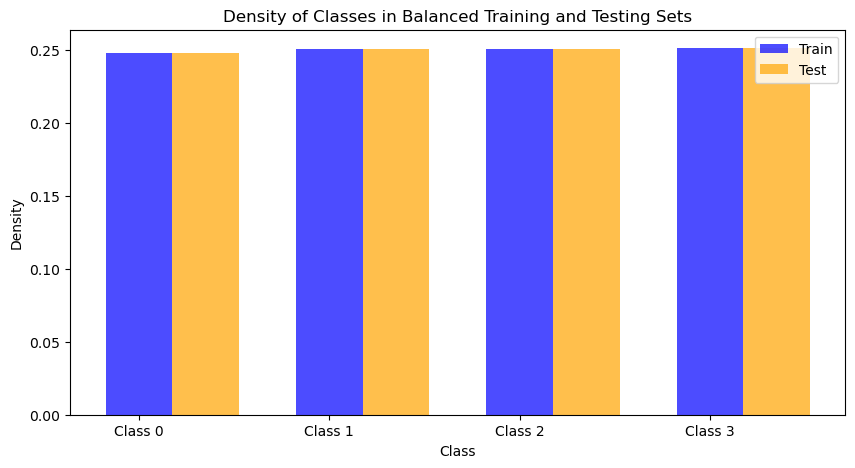

In [5]:
# Calculate the density of each class in the training set
train_class_density = y_train.value_counts(normalize=True).sort_index()

# Calculate the density of each class in the testing set
test_class_density = y_test.value_counts(normalize=True).sort_index()

# Create a bar plot to visualize the density of classes in the training and testing sets
plt.figure(figsize=(10, 5))
plt.bar(train_class_density.index, train_class_density.values, color='blue', alpha=0.7, label='Train', width=0.35)
plt.bar(test_class_density.index + 0.35, test_class_density.values, color='orange', alpha=0.7, label='Test', width=0.35)
plt.xlabel('Class')
plt.ylabel('Density')
plt.title('Density of Classes in Balanced Training and Testing Sets')
plt.xticks(range(4), ['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.legend()
plt.show()

The quantization method was chosen for balancing the dataset because it offers a straightforward approach to dividing the continuous "ChildPoverty" variable into four equal intervals, ensuring approximately equal representation of each class. This method avoids the need for complex sampling techniques and maintains the integrity of the original data distribution while achieving balance for classification tasks. Balancing the dataset for both the training and testing sets ensures that each class is represented proportionally, preventing bias in model training and providing a fair evaluation of the model's performance across all classes. This improves the model's ability to generalize well and accurately assess its performance on unseen data.

### 2. Pre-processing and Inital Modeling

In [6]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import sys

import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    

# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    
    
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
        

class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

#### 2.1 Without normalization and one-hot encoding

In [9]:
import time

# hyperparameters
eta = 0.001
minibatches = 64
random_state = 42
epochs = 50

# reuseable function
def train_and_test(X_train, X_test, y_train, y_test, num_runs = 1, plot_loss = False, return_detail_metrics=False):
    
    train_times, test_times, accs, f1s, precisions, recalls = [], [], [], [], [], []
    for i in range(num_runs):
        classifier = TLPBetterInitial(minibatches=minibatches, epochs=epochs, eta=eta, random_state=random_state+i)
        
        # train
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # test
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time
        
        if return_detail_metrics:
            # add metrics
            train_times.append(train_time)
            test_times.append(test_time)
            f1s.append(f1_score(y_test, y_pred, average="macro"))
            precisions.append(precision_score(y_test, y_pred, average="macro"))
            recalls.append(recall_score(y_test, y_pred, average="macro"))
        accs.append(accuracy_score(y_test, y_pred))
        
    if plot_loss:
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title("Training Loss")
        plt.plot(classifier.cost_)

    if return_detail_metrics:
        return np.mean(train_times), np.mean(test_times), np.mean(accs), np.mean(f1s), np.mean(precisions), np.mean(recalls)
    else:
        return np.mean(accs)

'Accuracy: 0.2508'

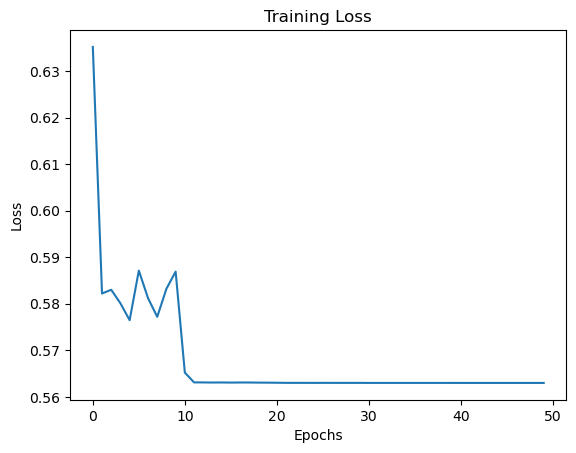

In [10]:
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

f'Accuracy: {train_and_test(X_train_np, X_test_np, y_train_np, y_test_np, plot_loss=True):.4f}'

#### 2.2 With normalization

'Accuracy: 0.7073'

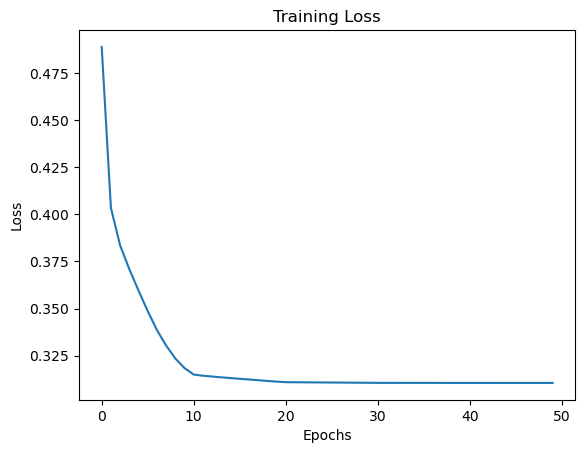

In [11]:
from sklearn.preprocessing import StandardScaler

# scale the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_np) 
X_test_norm = scaler.transform(X_test_np)

f'Accuracy: {train_and_test(X_train_norm, X_test_norm, y_train_np, y_test_np, plot_loss=True):.4f}'

#### 2.3 With normalization and one-hot encoding

'Accuracy: 0.7106'

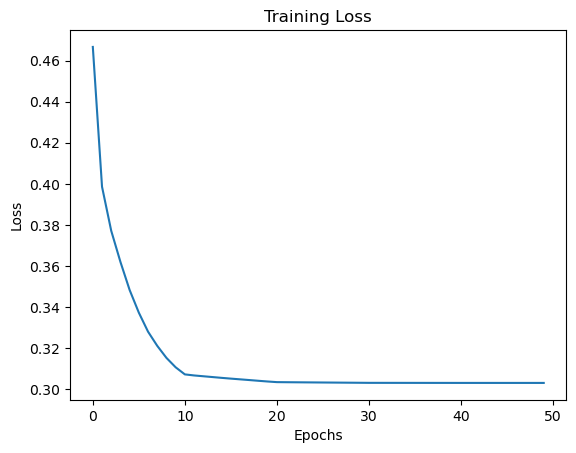

In [12]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encode the state column
encoder = OneHotEncoder()
onehot_train = encoder.fit_transform(X_train_np[:, 0:1]).toarray()
onehot_test = encoder.transform(X_test_np[:, 0:1]).toarray()

# scale the rest columns
scaler = StandardScaler()
numeric_train = scaler.fit_transform(X_train_np[:, 1:]) 
numeric_test = scaler.transform(X_test_np[:, 1:])

# stack them together
X_train_norm_onehot = np.hstack([onehot_train, numeric_train])
X_test_norm_onehot = np.hstack([onehot_test, numeric_test])

f'Accuracy: {train_and_test(X_train_norm_onehot, X_test_norm_onehot, y_train_np, y_test_np, plot_loss=True):.4f}'

#### 2.4 Performance Comparison

In [11]:
import warnings
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
warnings.filterwarnings('ignore')

num_runs = 5

# use thread pool to concurrently run the comparison 5 times for each version of data
metrics_list = ThreadPoolExecutor(3).map(lambda args: train_and_test(*args, y_train_np, y_test_np, num_runs, return_detail_metrics=True), 
                                         [(X_train_np, X_test_np),
                                          (X_train_norm, X_test_norm),
                                          (X_train_norm_onehot, X_test_norm_onehot)])

metrics_list = list(metrics_list)

In [12]:
# display the results
metric_df = pd.DataFrame(['w/o normalization & one-hot encoding', 'w/ normalization', 'w/ normalization & one-hot encoding'], columns=['Data'])
metric_df[['Training Time (s)', 'Testing Time (s)', 'Accuracy', 'F1 Score', 'Precision', 'Recall']] = metrics_list
metric_df

,Data,Training Time (s),Testing Time (s),Accuracy,F1 Score,Precision,Recall
0,w/o normalization & one-hot encoding,29.271638,0.052857,0.251788,0.105325,0.208002,0.251018
1,w/ normalization,15.294328,0.020943,0.708705,0.705069,0.705488,0.708891
2,w/ normalization & one-hot encoding,18.501175,0.018550,0.711867,0.709854,0.709301,0.712046


According to the training and testing results above, it is clear that without normalization and one-hot encoding, the model achieved the worst performance on the four metrics. By applying normalization to the data, the model achieved much better performance, while the training and testing time doubled. With normalization and one-hot encoding for the data, the model reached the highest performance on the four metrics. However, the one-hot encoding increased accuracy by only less than one percent compared to the accuracy using normalized data. Hence, we can conclude that normalization helps the model to classify the dataset, while one-hot encoding may not be as helpful as we thought for this particular dataset.

### 3. Modeling

#### 3.1  Add support for a third layer in the multi-layer perceptron

In [13]:
class ThreeLayerPerceptron():
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        b2 = np.zeros((self.n_hidden, 1))
        
        W3_num_elems = (self.n_hidden)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden)
        b3 = np.zeros((self.n_output_, 1))
        
        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] **2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape)
        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            eta = self.eta ** (1 + self.decrease_const * i)
            eta = max(eta, self.eta / 1000)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad1s, grad2s, grad3s = [], [], []
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                      )
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only
                

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)
                
                grad1s.append(np.mean(np.abs(gradW1)))
                grad2s.append(np.mean(np.abs(gradW2)))
                grad3s.append(np.mean(np.abs(gradW3)))
                
                # simple momentum calculations
                
                rho_W1, rho_W2 , rho_W3= eta * gradW1, eta * gradW2, eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
                

            self.grad_w1_.append(np.mean(np.abs(grad1s)))
            self.grad_w2_.append(np.mean(np.abs(grad2s)))
            self.grad_w3_.append(np.mean(np.abs(grad3s)))
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [14]:
# Define parameters
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

model_three = ThreeLayerPerceptron(**params)
model_three.fit(X_train_norm_onehot, y_train_np, print_progress=50)

Epoch: 200/200

Accuracy: 0.7238723872387238


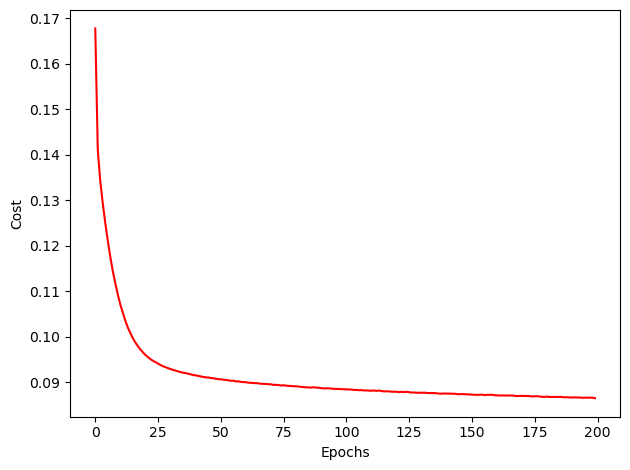

In [15]:
# Predict on test data
yhat_3 = model_three.predict(X_test_norm_onehot)

# Compute accuracy
accuracy = accuracy_score(y_test_np, yhat_3)
print('Accuracy:', accuracy)

# Plot cost over epochs
cost_avgs = [np.mean(x) for x in model_three.cost_]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

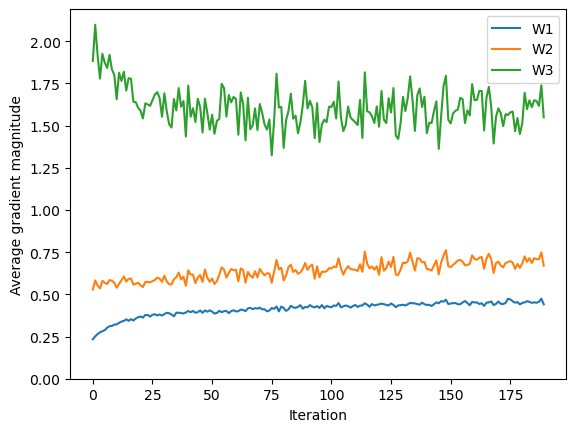

In [16]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.absolute(model_three.grad_w1_[10:]), label='W1')
plt.plot(np.absolute(model_three.grad_w2_[10:]), label='W2')
plt.plot(np.absolute(model_three.grad_w3_[10:]), label='W3')
plt.legend()
plt.ylim(0)
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

#### 3.2  Add support for a fourth layer


In [21]:
class FourLayerPerceptron():
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""

        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        b2 = np.zeros((self.n_hidden, 1))
        
        W3_num_elems = (self.n_hidden)*self.n_hidden
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden, self.n_hidden)
        b3 = np.zeros((self.n_hidden, 1))
        
        W4_num_elems = (self.n_hidden)*self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden)
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4
        

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2)) + np.mean(W4[:, 1:] ** 2)

    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A5)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W4: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a4 : activations into layer (or output layer)
        z1-z4 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = -2*(Y_enc-A5)*A5*(1-A5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)  # for momentum
        rho_W2_prev = np.zeros(self.W2.shape)  # for momentum
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(
                y_test, self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):
            eta = self.eta ** (1 + self.decrease_const * i)
            eta = max(eta, self.eta / 1000)

            if print_progress > 0 and (i+1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,
                                                                   idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad1s, grad2s, grad3s, grad4s = [], [], [], []

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                                       self.W1,
                                                                       self.W2,
                                                                       self.W3,
                                                                       self.W4,
                                                                       self.b1,
                                                                       self.b2,
                                                                       self.b3,
                                                                       self.b4,
                                                                       )
  

                cost = self._cost(A5, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4)
                mini_cost.append(cost)  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4
                                                                                                    ,Y_enc=Y_enc[:, idx],
                                                                                    W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)

                grad1s.append(np.mean(np.abs(gradW1)))
                grad2s.append(np.mean(np.abs(gradW2)))
                grad3s.append(np.mean(np.abs(gradW3)))
                grad4s.append(np.mean(np.abs(gradW4)))

                # simple momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4
                # update with momentum
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))

                # no need for momentum in bias
                # these values need to change abruptly and
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4

                # update previous parameters
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4

            self.grad_w1_.append(np.mean(np.abs(grad1s)))
            self.grad_w2_.append(np.mean(np.abs(grad2s)))
            self.grad_w3_.append(np.mean(np.abs(grad3s)))
            self.grad_w4_.append(np.mean(np.abs(grad4s)))
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [42]:
# set parameters for model training
params = dict(n_hidden=50,
              C=0.1,               # tradeoff L2 regularizer
              epochs=200,         # iterations
              eta=0.01,            # learning rate
              random_state=42,          
              minibatches=250,     # minibatch size
)
model_four = FourLayerPerceptron(**params)
model_four.fit(X_train_norm_onehot, y_train_np, print_progress=50)

Epoch: 200/200

Accuracy: 0.7176842684268426


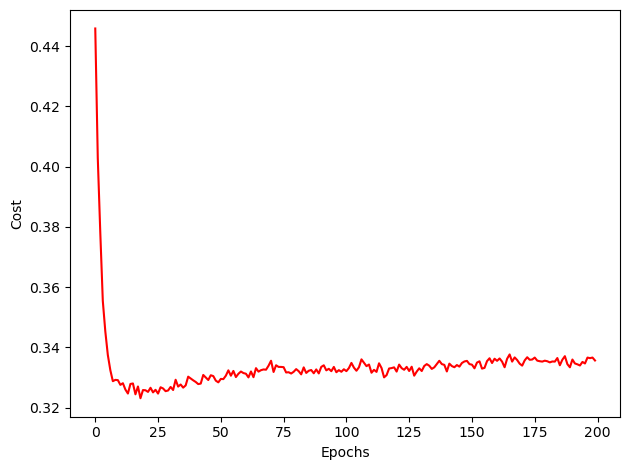

In [43]:
# Predict on test data
yhat_4 = model_four.predict(X_test_norm_onehot)

# Compute accuracy
accuracy = accuracy_score(y_test_np, yhat_4)
print('Accuracy:', accuracy)

# Plot cost over epochs
cost_avgs = [np.mean(x) for x in model_four.cost_]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


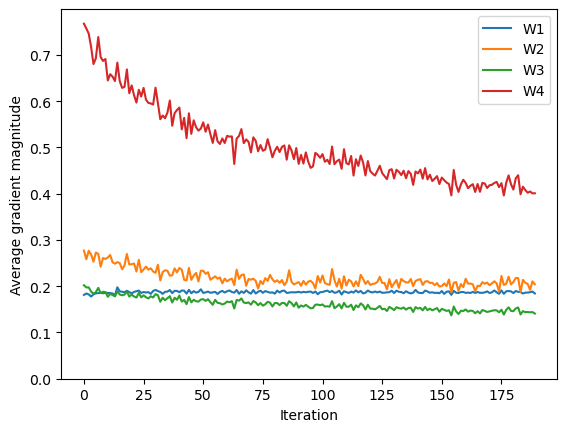

In [44]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.absolute(model_four.grad_w1_[10:]), label='W1')
plt.plot(np.absolute(model_four.grad_w2_[10:]), label='W2')
plt.plot(np.absolute(model_four.grad_w3_[10:]), label='W3')
plt.plot(np.absolute(model_four.grad_w4_[10:]), label='W4')
plt.legend()
plt.ylim(0)
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()


#### 3.3  Add support for a fifth layer

In [45]:
class FiveLayerPerceptron():
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        b2 = np.zeros((self.n_hidden, 1))
        
        W3_num_elems = (self.n_hidden)*self.n_hidden
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden, self.n_hidden)
        b3 = np.zeros((self.n_hidden, 1))
        
        W4_num_elems = (self.n_hidden)*self.n_hidden
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden, self.n_hidden)
        b4 = np.zeros((self.n_hidden, 1))
        
        W5_num_elems = (self.n_hidden)*self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden)
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W5: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a5 : activations into layer (or output layer)
        z1-z5 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)
        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []
        self.grad_w5_ = []
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            eta = self.eta ** (1 + self.decrease_const * i)
            eta = max(eta, self.eta / 1000)
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
            
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad1s, grad2s, grad3s, grad4s, grad5s = [], [], [], [], []
            
            for idx in mini:
                
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                       self.b4,
                                                       self.b5,
                                                      )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only
                
                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                grad1s.append(np.mean(np.abs(gradW1)))
                grad2s.append(np.mean(np.abs(gradW2)))
                grad3s.append(np.mean(np.abs(gradW3)))
                grad4s.append(np.mean(np.abs(gradW4)))
                grad5s.append(np.mean(np.abs(gradW5)))
                
                # simple momentum calculations
                rho_W1, rho_W2 , rho_W3, rho_W4, rho_W5 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum
                
                # no need for momentum in bias
                # these values need to change abruptly and
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
                # update previous parameters
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5
        
            self.grad_w1_.append(np.mean(np.abs(grad1s)))
            self.grad_w2_.append(np.mean(np.abs(grad2s)))
            self.grad_w3_.append(np.mean(np.abs(grad3s)))
            self.grad_w4_.append(np.mean(np.abs(grad4s)))
            self.grad_w5_.append(np.mean(np.abs(grad5s)))
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self
    

In [46]:
model_five = FiveLayerPerceptron(**params)
model_five.fit(X_train_norm_onehot, y_train_np, print_progress=50)

Epoch: 200/200

Accuracy: 0.721465896589659


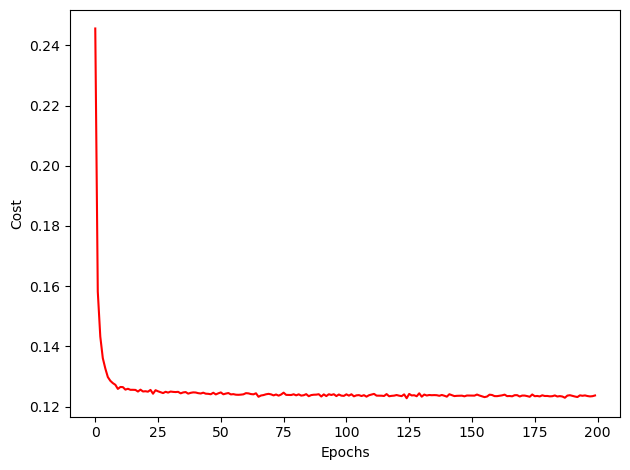

In [47]:
# predict on test data
yhat_5 = model_five.predict(X_test_norm_onehot)

# compute accuracy
accuracy = accuracy_score(y_test_np, yhat_5)
print('Accuracy:', accuracy)

# plot cost over epochs
cost_avgs = [np.mean(x) for x in model_five.cost_]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red') 
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


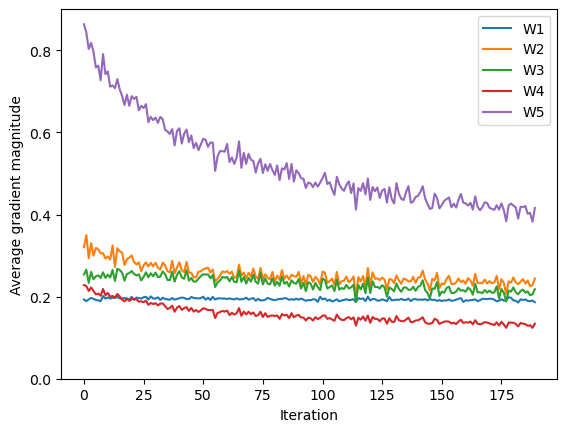

In [48]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.absolute(model_five.grad_w1_[10:]), label='W1')
plt.plot(np.absolute(model_five.grad_w2_[10:]), label='W2')
plt.plot(np.absolute(model_five.grad_w3_[10:]), label='W3')
plt.plot(np.absolute(model_five.grad_w4_[10:]), label='W4')
plt.plot(np.absolute(model_five.grad_w5_[10:]), label='W5')
plt.legend()
plt.ylim(0)
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()



### 3.4 Implement an Adaptive Method. Compare the performance of your five layer model with and without the adaptive

#### Implementing RMSProp in the Five-Layer Perceptron

In [57]:
class FiveLayerPerceptronRMSProp(FiveLayerPerceptron):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1,
                 decay_rate=0.9, epsilon=1e-8):
        super().__init__(n_hidden, C, epochs, eta, random_state, alpha, decrease_const, shuffle, minibatches)
        self.decay_rate = decay_rate
        self.epsilon = epsilon

    def _fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # RMSProp cache initialization
        cache_W1 = np.zeros_like(self.W1)
        cache_W2 = np.zeros_like(self.W2)
        cache_W3 = np.zeros_like(self.W3)
        cache_W4 = np.zeros_like(self.W4)
        cache_W5 = np.zeros_like(self.W5)
        cache_b1 = np.zeros_like(self.b1)
        cache_b2 = np.zeros_like(self.b2)
        cache_b3 = np.zeros_like(self.b3)
        cache_b4 = np.zeros_like(self.b4)
        cache_b5 = np.zeros_like(self.b5)
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)
        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []
        self.grad_w5_ = []
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            eta = self.eta ** (1 + self.decrease_const * i)
            eta = max(eta, self.eta / 1000)
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
            
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad1s, grad2s, grad3s, grad4s, grad5s = [], [], [], [], []
            
            for idx in mini:
                
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                       self.b4,
                                                       self.b5,
                                                      )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only
                
                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                
                grad1s.append(np.mean(np.abs(gradW1)))
                grad2s.append(np.mean(np.abs(gradW2)))
                grad3s.append(np.mean(np.abs(gradW3)))
                grad4s.append(np.mean(np.abs(gradW4)))
                grad5s.append(np.mean(np.abs(gradW5)))
                
                # RMSProp cache update
                cache_W1 = self.decay_rate * cache_W1 + (1 - self.decay_rate) * gradW1 ** 2
                cache_W2 = self.decay_rate * cache_W2 + (1 - self.decay_rate) * gradW2 ** 2
                cache_W3 = self.decay_rate * cache_W3 + (1 - self.decay_rate) * gradW3 ** 2
                cache_W4 = self.decay_rate * cache_W4 + (1 - self.decay_rate) * gradW4 ** 2
                cache_W5 = self.decay_rate * cache_W5 + (1 - self.decay_rate) * gradW5 ** 2
                
                # update weights
                self.W1 -= self.eta * gradW1 / (np.sqrt(cache_W1) + self.epsilon)
                self.W2 -= self.eta * gradW2 / (np.sqrt(cache_W2) + self.epsilon)
                self.W3 -= self.eta * gradW3 / (np.sqrt(cache_W3) + self.epsilon)
                self.W4 -= self.eta * gradW4 / (np.sqrt(cache_W4) + self.epsilon)
                self.W5 -= self.eta * gradW5 / (np.sqrt(cache_W5) + self.epsilon)
                
                # no need for momentum in bias
                # these values need to change abruptly and
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
            self.grad_w1_.append(np.mean(np.abs(grad1s)))
            self.grad_w2_.append(np.mean(np.abs(grad2s)))
            self.grad_w3_.append(np.mean(np.abs(grad3s)))
            self.grad_w4_.append(np.mean(np.abs(grad4s)))
            self.grad_w5_.append(np.mean(np.abs(grad5s)))
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self


### Performance Comparison

In [58]:
import time

# hyperparameters
eta = 0.001
minibatches = 64
random_state = 42
epochs = 20
n_hidden = 50
c = 0.1


def compare_models(X_train, X_test, y_train, y_test, num_runs):
    metrics = {
        'flp':{'train_time':[], 'test_time':[], 'accuracy':[], 'f1':[], 'precision':[], 'recall':[]},
        'flp_rms':{'train_time':[], 'test_time':[], 'accuracy':[], 'f1':[], 'precision':[], 'recall':[]}
        }
    
    # Initialize the models
    for i in range(num_runs):
        flp = FiveLayerPerceptron(eta=eta, minibatches=minibatches, random_state=random_state, epochs=epochs, n_hidden=n_hidden, C=c)
        flp_rms = FiveLayerPerceptronRMSProp(eta=eta, minibatches=minibatches, random_state=random_state, epochs=epochs, n_hidden=n_hidden, C=c)
        
        # Train and Test FiveLayerPerceptron
        start_time = time.time()
        flp.fit(X_train, y_train)
        metrics['flp']['train_time'].append(time.time() - start_time)
        
        strat_time = time.time()
        y_pred_flp = flp.predict(X_test)
        metrics['flp']['test_time'].append(time.time() - start_time)
        metrics['flp']['accuracy'].append(accuracy_score(y_test, y_pred_flp))
        metrics['flp']['f1'].append(f1_score(y_test, y_pred_flp, average='macro'))
        metrics['flp']['precision'].append(precision_score(y_test, y_pred_flp, average='macro'))
        metrics['flp']['recall'].append(recall_score(y_test, y_pred_flp, average='macro'))
        
        # Train and Test FiveLayerPerceptronRMSProp
        start_time = time.time()
        flp_rms.fit(X_train, y_train)
        metrics['flp_rms']['train_time'].append(time.time() - start_time)
        
        strat_time = time.time()
        y_pred_flp_rms = flp_rms.predict(X_test)
        metrics['flp_rms']['test_time'].append(time.time() - start_time)
        metrics['flp_rms']['accuracy'].append(accuracy_score(y_test, y_pred_flp_rms))
        metrics['flp_rms']['f1'].append(f1_score(y_test, y_pred_flp_rms, average='macro'))
        metrics['flp_rms']['precision'].append(precision_score(y_test, y_pred_flp_rms, average='macro'))
        metrics['flp_rms']['recall'].append(recall_score(y_test, y_pred_flp_rms, average='macro'))
    
    # # Plot gradient magnitudes
    # epochs_range= range(1, epochs + 1)
    # plt.figure(figsize=(12, 6))
    # for layer in ['W1', 'W2', 'W3', 'W4', 'W5']:  # Assuming these are your layer identifiers
    #     magnitudes = [np.mean([epoch[layer] for epoch in flp.grad_history_]) for epoch in epochs_range]
    #     plt.plot(epochs_range, magnitudes, label=f'{layer} - FiveLayerPerceptron')
    #     magnitudes = [np.mean([epoch[layer] for epoch in flp_rms.grad_history_]) for epoch in epochs_range]
    #     plt.plot(epochs_range, magnitudes, label=f'{layer} - FiveLayerPerceptronRMSProp')
    
     # Plot gradient magnitudes
    plt.figure(figsize=(12, 6))
    layers = ['W1', 'W2', 'W3', 'W4', 'W5']
    for layer in layers:
        magnitudes_flp = [history[layer] for history in flp.grad_history_]
        magnitudes_flp_rms = [history[layer]
                              for history in flp_rms.grad_history_]
        plt.plot(magnitudes_flp, label=f'{layer} - FiveLayerPerceptron')
        plt.plot(magnitudes_flp_rms, '--',
                 label=f'{layer} - FiveLayerPerceptronRMSProp')
     
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Magnitude')
    plt.title('Gradient Magnitudes of FiveLayerPerceptron and FiveLayerPerceptronRMSProp')
    plt.legend()
    plt.show()
    
    # Print performance metrics
    for model, data in metrics.items:
        print(f"{model} Performance:")
        for metric, values in data.items():
            print(f"{metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")


compare_models(X_train_norm_onehot, X_test_norm_onehot,
               y_train_np, y_test_np, num_runs=5)


AttributeError: 'FiveLayerPerceptron' object has no attribute 'grad_history_'

<Figure size 1200x600 with 0 Axes>

In [59]:
class FiveLayerPerceptronAdaM(FiveLayerPerceptron):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1,
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(n_hidden, C, epochs, eta, random_state, alpha, decrease_const, shuffle, minibatches)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_W1, self.m_W2, self.m_W3, self.m_W4, self.m_W5 = None, None, None, None, None
        self.v_W1, self.v_W2, self.v_W3, self.v_W4, self.v_W5 = None, None, None, None, None
        self.m_b1, self.m_b2, self.m_b3, self.m_b4, self.m_b5 = None, None, None, None, None
        self.v_b1, self.v_b2, self.v_b3, self.v_b4, self.v_b5 = None, None, None, None, None

    def _init_adam_params(self, shape):
        return np.zeros(shape), np.zeros(shape)

    def _update_adam_params(self, param, grad, m, v, t):
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
        m_hat = m / (1 - self.beta1 ** t)
        v_hat = v / (1 - self.beta2 ** t)
        param -= self.eta * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return param, m, v

    def _fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
        self.m_W1, self.m_W2, self.m_W3, self.m_W4, self.m_W5 = self._init_adam_params(self.W1.shape), self._init_adam_params(self.W2.shape), self._init_adam_params(self.W3.shape), self._init_adam_params(self.W4.shape), self._init_adam_params(self.W5.shape)
        self.v_W1, self.v_W2, self.v_W3, self.v_W4, self.v_W5 = self._init_adam_params(self.W1.shape), self._init_adam_params(self.W2.shape), self._init_adam_params(self.W3.shape), self._init_adam_params(self.W4.shape), self._init_adam_params(self.W5.shape)
        self.m_b1, self.m_b2, self.m_b3, self.m_b4, self.m_b5 = np.zeros_like(self.b1), np.zeros_like(self.b2), np.zeros_like(self.b3), np.zeros_like(self.b4), np.zeros_like(self.b5)
        self.v_b1, self.v_b2, self.v_b3, self.v_b4, self.v_b5 = np.zeros_like(self.b1), np.zeros_like(self.b2), np.zeros_like(self.b3), np.zeros_like(self.b4), np.zeros_like(self.b5)
        
        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []
        self.grad_w5_ = []
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
            
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad1s, grad2s, grad3s, grad4s, grad5s = [], [], [], [], []
            
            for idx in mini:
                
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                       self.b4,
                                                       self.b5,
                                                      )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only
                
                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                
                grad1s.append(np.mean(np.abs(gradW1)))
                grad2s.append(np.mean(np.abs(gradW2)))
                grad3s.append(np.mean(np.abs(gradW3)))
                grad4s.append(np.mean(np.abs(gradW4)))
                grad5s.append(np.mean(np.abs(gradW5)))
                
                # AdaM parameter updates
                t = i * len(mini) + idx + 1
                self.W1, self.m_W1, self.v_W1 = self._update_adam_params(self.W1, gradW1, self.m_W1, self.v_W1, t)
                self.W2, self.m_W2, self.v_W2 = self._update_adam_params(self.W2, gradW2, self.m_W2, self.v_W2, t)
                self.W3, self.m_W3, self.v_W3 = self._update_adam_params(self.W3, gradW3, self.m_W3, self.v_W3, t)
                self.W4, self.m_W4, self.v_W4 = self._update_adam_params(self.W4, gradW4, self.m_W4, self.v_W4, t)
                self.W5, self.m_W5, self.v_W5 = self._update_adam_params(self.W5, gradW5, self.m_W5, self.v_W5, t)
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5
                
            self.grad_w1_.append(np.mean(np.abs(grad1s)))
            self.grad_w2_.append(np.mean(np.abs(grad2s)))
            self.grad_w3_.append(np.mean(np.abs(grad3s)))
            self.grad_w4_.append(np.mean(np.abs(grad4s)))
            self.grad_w5_.append(np.mean(np.abs(grad5s)))
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self


References:
1. https://www.kaggle.com/muonneutrino/us-census-demographic-data/data